# <div align="center"><b> ПРОГНОЗИРОВАНИЕ ЗАКАЗОВ ТАКСИ </b></div> 

**Цель:** создание модели, осуществляющую прогноз количества заказов такси на следующий час; <br/>
**Заказчик:** компания "Четенькое такси".

# 1. Подготовка данных

In [52]:
#импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import pandas_profiling
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit

In [53]:
#сформируем датафрейм
try:
    #берем данные с локального компьютера
    df = pd.read_csv(r'C:\Users\vizum\Desktop\yandex_practicum\project_12\datasets\taxi.csv')
except:
    #берем данные с хранилища Яндекс.Практикума
    df=pd.read_csv('/datasets/taxi.csv')
df

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [54]:
#получим общую информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [55]:
#переведем столбец 'datetime' в формат datetime
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [56]:
#установим время и дату в качестве индекса
df.set_index('datetime', inplace=True)
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [57]:
#проверим упорядоченность временного ряда
print(df.index.is_monotonic)

True


Временной ряд упорядочен.

In [58]:
#выполним ресемплирование данных по одному часу
#так как целевой признак - объем заказов в час, в качестве аггрегирующей функции выберем сумму
df=df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# 2. Анализ временного ряда

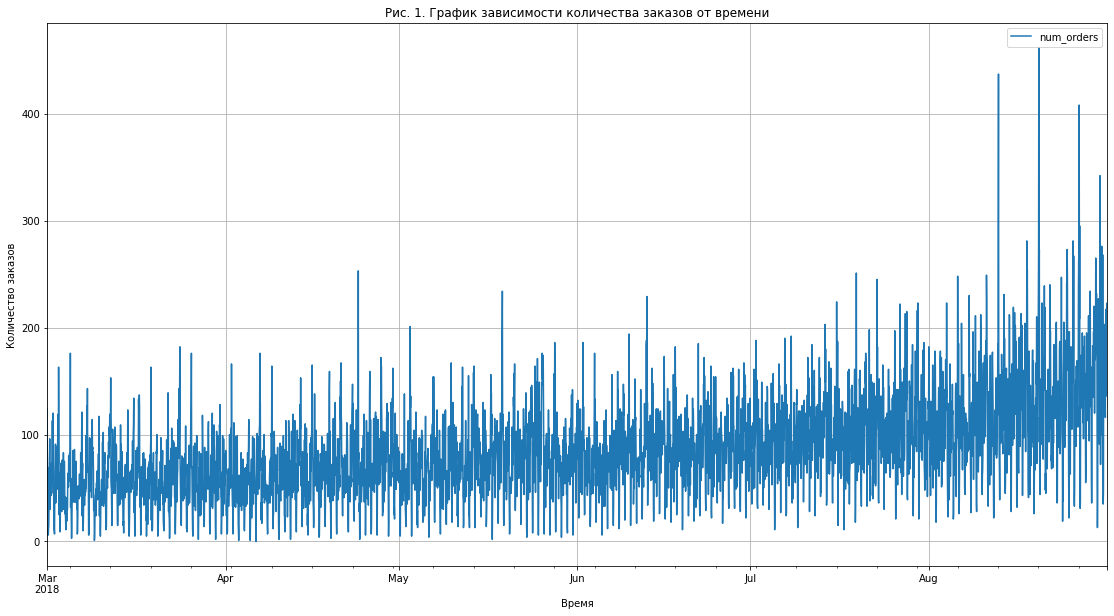

In [59]:
#построим график зависимости количества заказов от времени
df.plot(figsize=(19,10), grid=True)
plt.title('Рис. 1. График зависимости количества заказов от времени')
plt.xlabel('Время')
plt.ylabel('Количество заказов');

На рис. 1 выделяется общая тенденция роста количества заказов в течение полугода с марта по сентябрь. Это может быть вызвано разными причинами: увеличением популярности сервиса или, например, наплывом туристов - если в городе есть какие-то достопримечательности, которые можно посмотреть во второй половине лета... Трудно сказать, поскольку данные известны только за полгода. 

Выделяются также периодические колебания на всем графике и шумы. Построим графики тренда, сезонной составляющей и шумов.

In [60]:
#выполним декомпозицию данных
decomposed = seasonal_decompose(df)

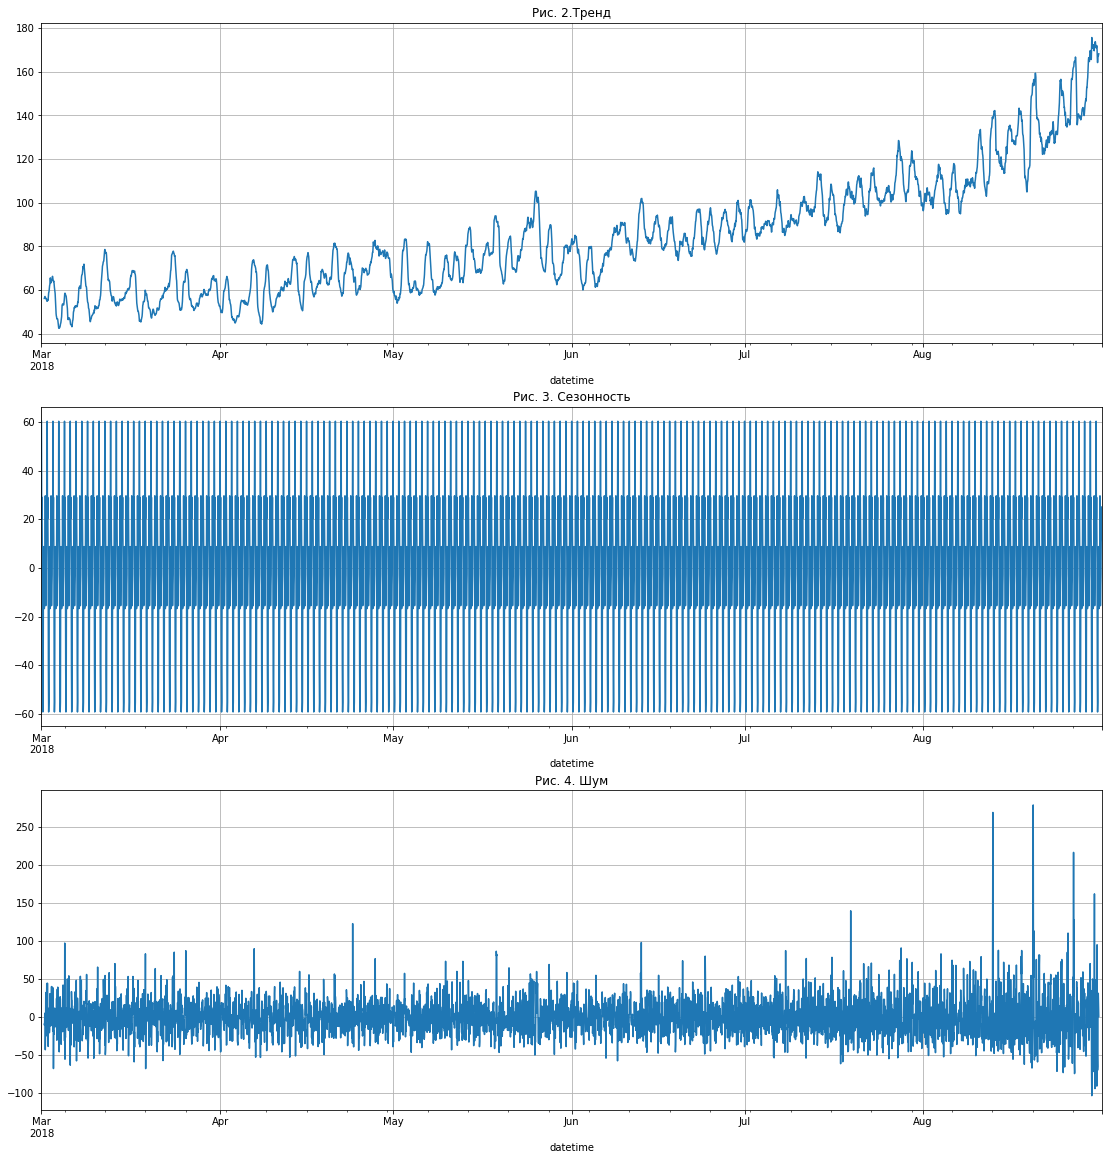

In [61]:
#построим графики

#график тренда
plt.figure(figsize=(19,20))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), grid=True)
plt.title('Рис. 2.Тренд')

#график сезонности
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), grid=True)
plt.title('Рис. 3. Сезонность')

#график шума
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), grid=True)
plt.title('Рис. 4. Шум');

Из графиков на рис. 2-4 можно сказать следующее: 
- Количество заказов действительно увеличивается к концу лета, при этом график тренда нестационарен;
- График шума близок к стационарному;
- График сезонности стационарен и имеет четко выраженные периоды. Рассмотрим его подробнее.

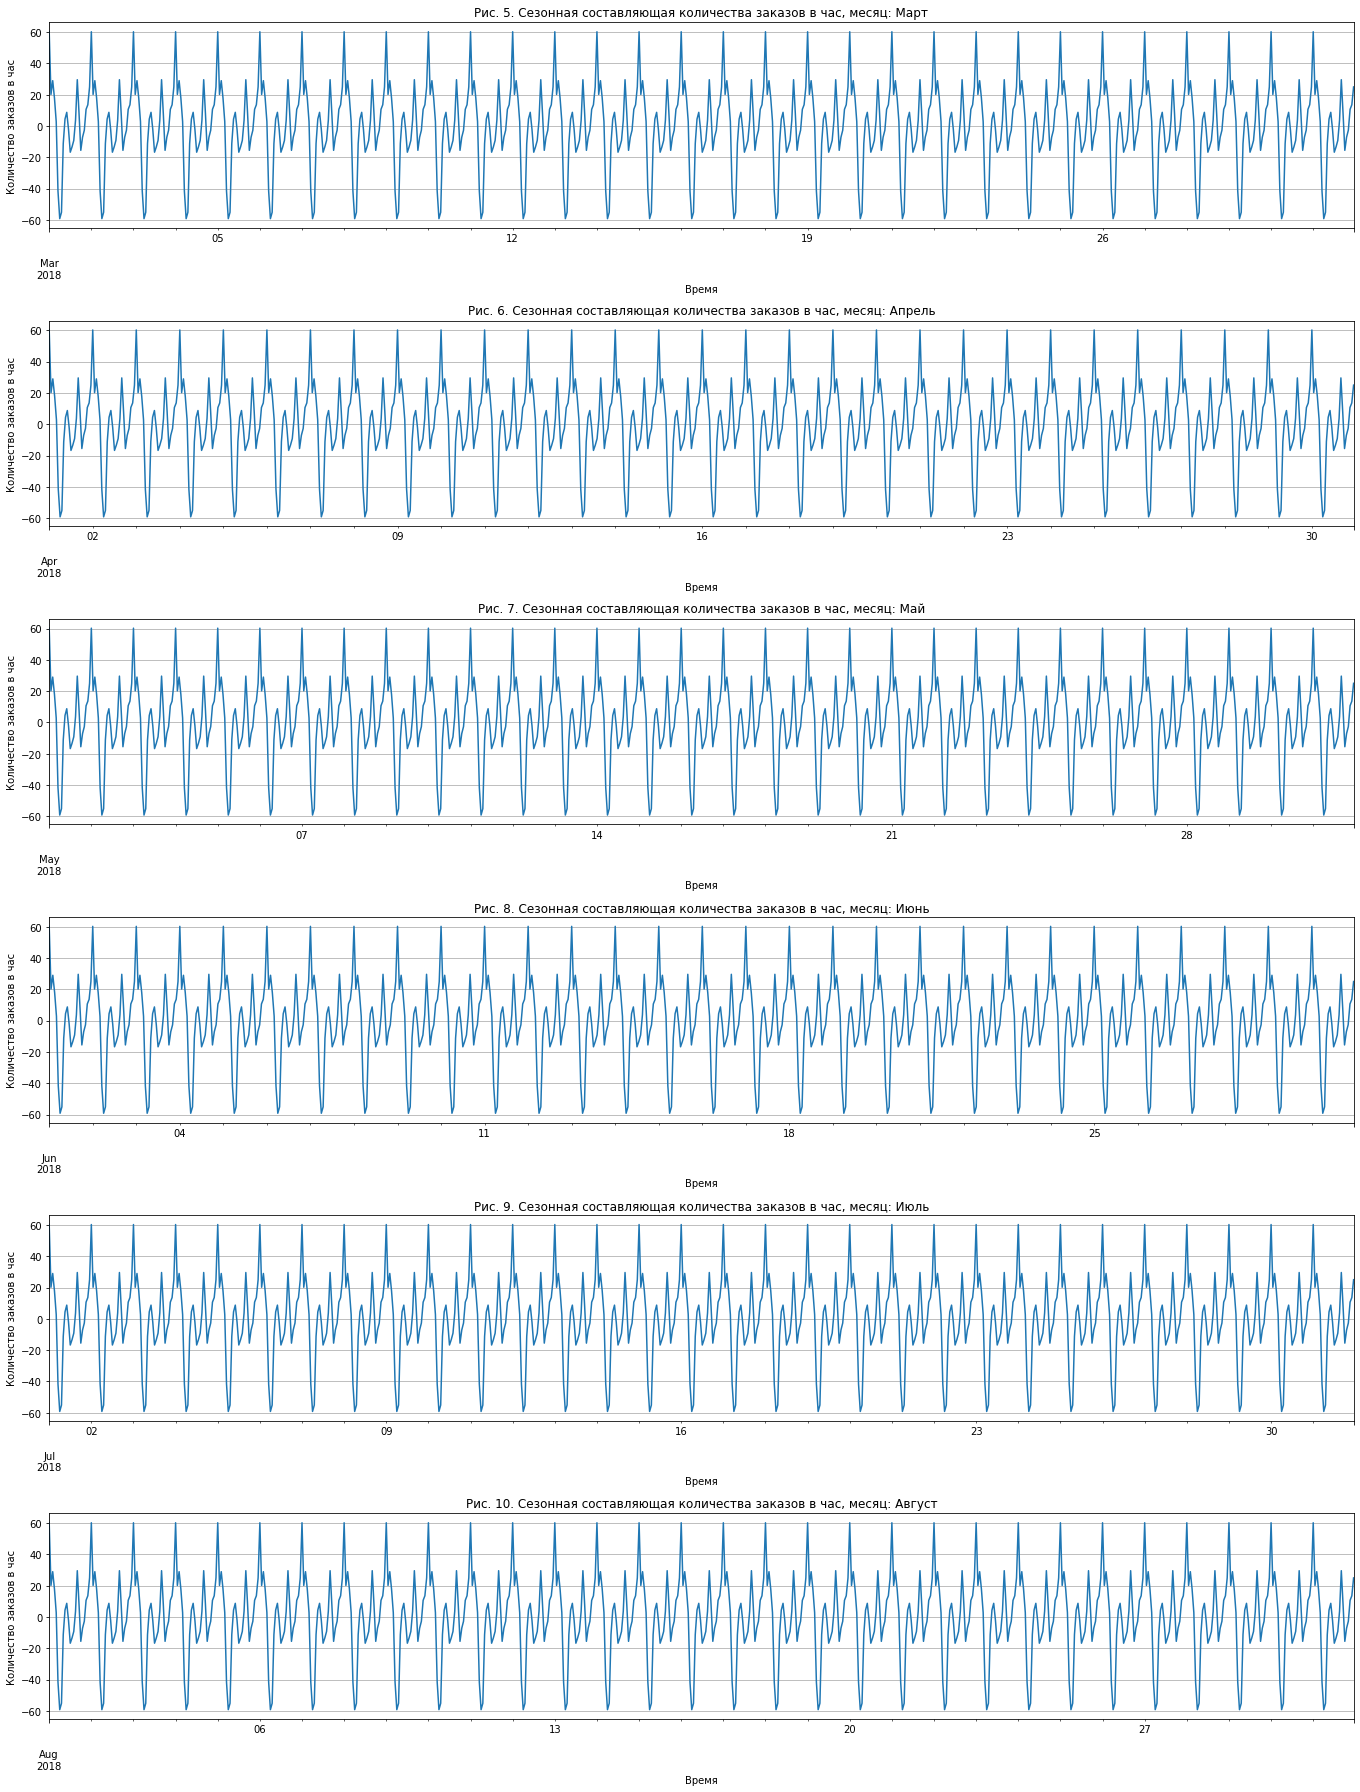

In [62]:
#составим график сезонности для каждого месяца
months={3:'Март', 4:'Апрель', 5:'Май', 6:'Июнь', 7:'Июль', 8:'Август'}
plt.figure(figsize=(19,25))
for i in range(3, 9):
    plt.subplot(610+i-2)
    decomposed.seasonal['2018-0'+str(i)].plot(ax=plt.gca(), grid=True)
    plt.title('Рис. '+str(i+2)+'. Сезонная составляющая количества заказов в час, месяц: '+ months[i])
    plt.xlabel('Время')
    plt.ylabel('Количество заказов в час')
plt.tight_layout()

Анализируя графики на рис. 5-10, можно сказать, что сезонная составляющая постоянна и не зависит от месяца. Рассмотрим график сезонности в боле крупном масштабе.

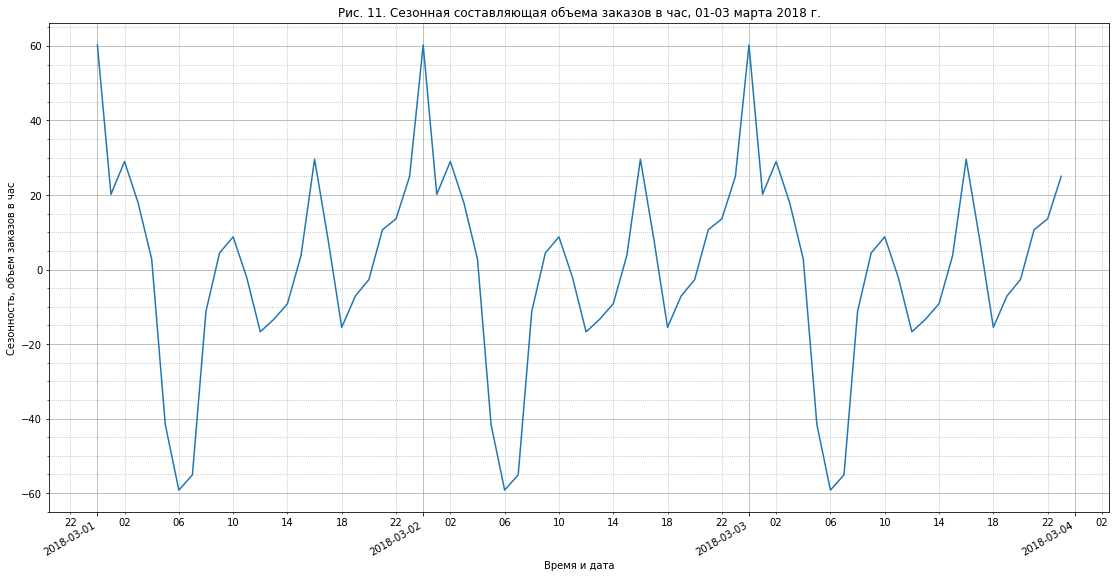

In [63]:
#составим график сезонности за 1-3 марта
decomposed.seasonal['2018-03-01':'2018-03-03'].plot(ax=plt.gca(), figsize=(19,10), x_compat=True)
plt.xlabel('Время и дата')
plt.ylabel('Сезонность, объем заказов в час')
plt.title('Рис. 11. Сезонная составляющая объема заказов в час, 01-03 марта 2018 г.')

#настроим деления временной оси
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 1)) 
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval = 4)) 
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))


Анализируя графики сезонности на рис. 5-11, можно сделать следующие выводы:
- сезонная составляющая не зависит от месяца;
- периодичность сезонной составляющей - сутки;
- максимальное значение сезонности призодится на полночь (+60), минимальное - на 6 часов утра (-60);
- наблюдаются локальные максимумы в 10 и 16 ч, локальные минмумы в 12 и в 18 ч.

# 3. Обучение моделей

В текущем разделе обучим три модели прогноза заказов такси. Используем следующие алгоритмы:
- линейную регрессию;
- градиентный бустинг на базе библиотеки LightGBM;
- дерево решений.

Выбор наилучшей модели будем осуществлять кроссвалидацией с подбором гиперпараметров (кроме линейной регрессии) и наилучшей конфигурации признаков (количество лагов, ширину окна вычисления скользящего среднего).

В качестве метрики будем использовать показатель RMSE - согласно заданию на проект. **RMSE выбранной модели должна быть не более 48 заказов в час**.

## 3.1 Создание вспомогательных функций

In [64]:
#создадим функцию для выделения признаков
def make_features(data, max_lag, rolling_mean_size):
    
    #создадим календарные признаки
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    #создадим временные разности
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    #вычислим среднее значение целевого признака за определенный период
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [65]:
#проверим работу функции
test=df.head(10).copy()
make_features(test, 4, 3)
test

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,93.333333
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,74.000000
2018-03-01 05:00:00,6,3,1,3,43.0,66.0,71.0,85.0,60.000000
2018-03-01 06:00:00,12,3,1,3,6.0,43.0,66.0,71.0,38.333333
2018-03-01 07:00:00,15,3,1,3,12.0,6.0,43.0,66.0,20.333333
2018-03-01 08:00:00,34,3,1,3,15.0,12.0,6.0,43.0,11.000000


In [66]:
#создадим функцию, создающую признаки и делящую датафрейм на обучающую и тестовую выборки
def make_samples(data, test_size, lag, roll):
    
        #копируем исходный датафрейм, признаки будем создавать в копии
        df_with_features = data.copy()
        
        #создадим признаки
        make_features(df_with_features, lag, roll)
        
        #разделим датафрейм с признаками на обучающую и тестовую части
        train, test = train_test_split(df_with_features, shuffle=False, test_size=test_size)
        
        #удалим NaN
        train = train.dropna()
        
        #выделим обучающие признаки и целевой признак в обучающей и тестовой выборках
        features_train = train.drop(columns='num_orders')
        target_train = train['num_orders']
        features_test = test.drop(columns='num_orders')
        target_test = test['num_orders']
        
        #результат работы функции - четыре выборки
        return features_train, target_train, features_test, target_test

In [67]:
#создадим функцию для обучения моделей с помощью инструмента GridSearch
#algorythm - алгоритм обучения
#parameters - сетка гиперпараметров
#list_result - словарь-хранилище результатов
def training(algorythm, parameters, list_result):
    for lag in range(0, 73, 12):
        for roll in range(1, 25, 1):
            features_train, target_train, features_test, target_test = make_samples(df, 0.1, lag, roll)
            model = GridSearchCV(algorythm, param_grid=parameters, scoring = 'neg_root_mean_squared_error', cv=TimeSeriesSplit(), verbose=1)
            model.fit(features_train, target_train)
            
            #добавим индикатор выполнения процесса
            print(lag, roll, model.best_score_)
          
            list_result['n_lags'].append(lag)
            list_result['roll_size'].append(roll)
            list_result['score'].append(model.best_score_)
            list_result['best_params'].append(model.best_params_)

## 3.2 Обучение модели на основе линейной регрессии

Обучим модель на основе линейной регрессии. Качество модели, соответствующее каждому из значений количества лагов и ширины скользящего окна, сохраним в словаре.

In [68]:
%%time

#словарь для хранения результатов
lr_result={'n_lags':[], 'roll_size':[], 'score':[]}
tscv=TimeSeriesSplit()

#обучим модель при разных наборах признаков
for lag in range(0, 73, 12):
    for roll in range(1, 25, 1):
        
        #создаем нужные выборки
        features_train, target_train, features_test, target_test = make_samples(df, 0.1, lag, roll)
        model_lr = LinearRegression()
        
        #получаем список RMSE моделей на кроссвалидации
        scores_lr = cross_val_score(model_lr, features_train, target_train, cv=tscv, scoring='neg_root_mean_squared_error')
        
        #сохраняем результаты
        lr_result['n_lags'].append(lag)
        lr_result['roll_size'].append(roll)
        lr_result['score'].append(pd.Series(scores_lr).mean())

CPU times: total: 16.8 s
Wall time: 15.7 s


In [69]:
#посмотрим на 5 оптимальных пар "количество лагов - ширина окна", соответствующих пяти наилучшим значениям RMSE
lr_result = pd.DataFrame(lr_result)
lr_result.sort_values(by='score', ascending=False).head()

,n_lags,roll_size,score
92,36,21,-26.587318
81,36,10,-26.589759
79,36,8,-26.590149
77,36,6,-26.590534
87,36,16,-26.591009


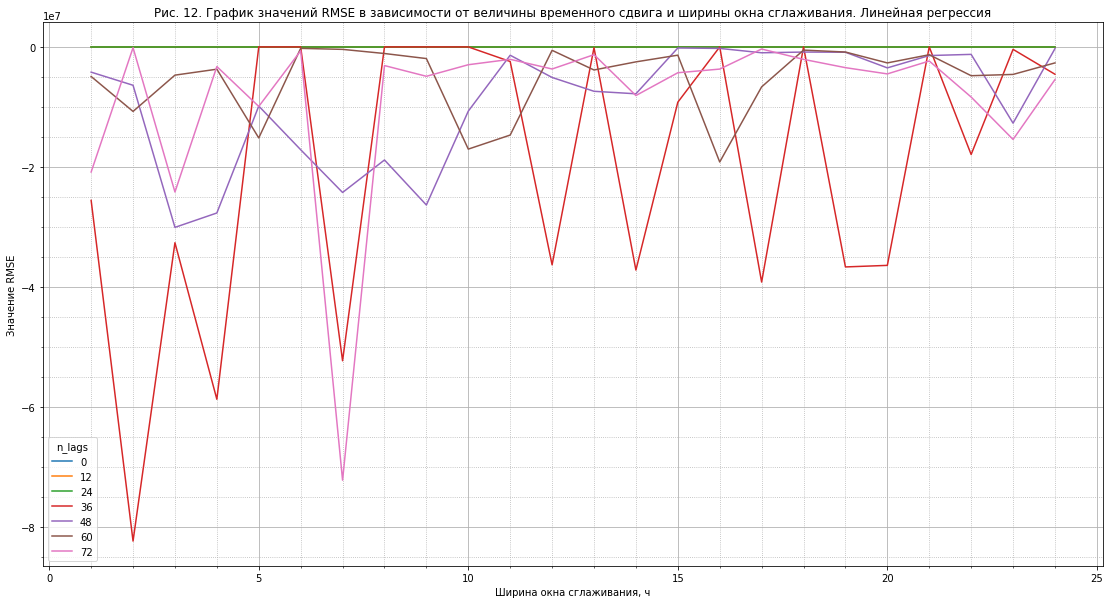

In [70]:
#построим график значений RMSE в зависимости от сочетания "количество лагов - ширина окна"
pd.DataFrame(lr_result).pivot_table(index='roll_size', columns='n_lags', values='score', aggfunc='min').plot(figsize=(19, 10))

#добавим оформление
plt.xlabel('Ширина окна сглаживания, ч')
plt.ylabel('Значение RMSE')
plt.title('Рис. 12. График значений RMSE в зависимости от величины временного сдвига и ширины окна сглаживания. Линейная регрессия')
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')

Наилучшее значение метрики RMSE для модели на основе линейной регрессии наблюдается при количестве лагов 36 и ширине окна 21 и составляет **26.6 заказов в час**.

## 3.3 Обучение модели градиентным бустингом (LightGBM)

Обучим модель на основе случайного леса с помощью градиентного бустинга. Качество наилучшей модели, соответствующее каждому из значений количества лагов и ширины скользящего окна, а также гиперпараметры наилучшей модели сохраним в словаре.

In [71]:
%%time

#зададим сетку гиперпараметров
lgbm_params = {'n_estimators':[10, 20, 30, 40, 50], 'max_depth':[1, 2, 3, 4, 5, 6, 7], 'reg_lambda':[0, 0.3, 0.7]}

#создадим хранилище результатов
lgbm_result={'n_lags':[], 'roll_size':[], 'score':[], 'best_params':[]}

#обучим модель
training(LGBMRegressor(), lgbm_params, lgbm_result)

Fitting 5 folds for each of 105 candidates, totalling 525 fits
0 1 -32.12287067896047
Fitting 5 folds for each of 105 candidates, totalling 525 fits
0 2 -33.11000623527472
Fitting 5 folds for each of 105 candidates, totalling 525 fits
0 3 -34.177339805433974
Fitting 5 folds for each of 105 candidates, totalling 525 fits
0 4 -34.829284709467636
Fitting 5 folds for each of 105 candidates, totalling 525 fits
0 5 -35.35029158674424
Fitting 5 folds for each of 105 candidates, totalling 525 fits
0 6 -35.65263878223093
Fitting 5 folds for each of 105 candidates, totalling 525 fits
0 7 -35.91173945542475
Fitting 5 folds for each of 105 candidates, totalling 525 fits
0 8 -35.86960209223498
Fitting 5 folds for each of 105 candidates, totalling 525 fits
0 9 -36.16536428485838
Fitting 5 folds for each of 105 candidates, totalling 525 fits
0 10 -36.30426245199221
Fitting 5 folds for each of 105 candidates, totalling 525 fits
0 11 -36.10711126228873
Fitting 5 folds for each of 105 candidates, totall

In [72]:
#посмотрим на 5 оптимальных пар "количество лагов - ширина окна", соответствующих пяти наилучшим значениям RMSE
lgbm_result = pd.DataFrame(lgbm_result)
lgbm_result.sort_values(by='score', ascending=False).head()

,n_lags,roll_size,score,best_params
150,72,7,-23.715861,"{'max_depth': 6, 'n_estimators': 50, 'reg_lamb..."
149,72,6,-23.748742,"{'max_depth': 5, 'n_estimators': 50, 'reg_lamb..."
151,72,8,-23.809996,"{'max_depth': 7, 'n_estimators': 50, 'reg_lamb..."
161,72,18,-23.827751,"{'max_depth': 5, 'n_estimators': 50, 'reg_lamb..."
156,72,13,-23.832089,"{'max_depth': 5, 'n_estimators': 50, 'reg_lamb..."


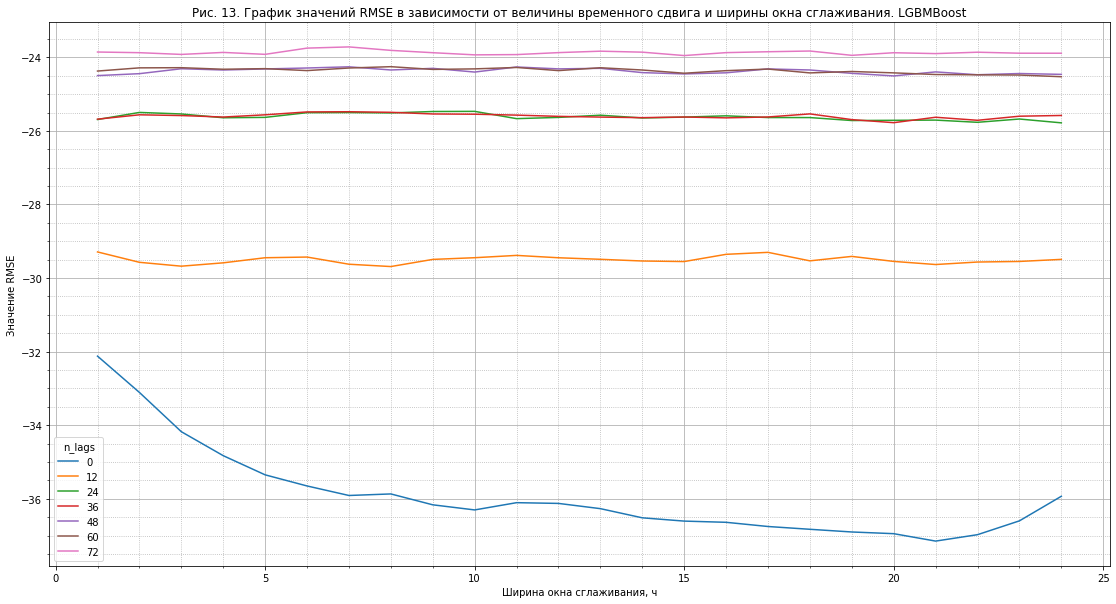

In [73]:
#построим график значений RMSE в зависимости от сочетания "количество лагов - ширина окна"
pd.DataFrame(lgbm_result).pivot_table(index='roll_size', columns='n_lags', values='score', aggfunc='min').plot(figsize=(19, 10))

#добавим оформление
plt.xlabel('Ширина окна сглаживания, ч')
plt.ylabel('Значение RMSE')
plt.title('Рис. 13. График значений RMSE в зависимости от величины временного сдвига и ширины окна сглаживания. LGBMBoost')
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')

Наилучшее качество наблюдается для модели, обученной на выборке с 72-мя лагами и ширине скользящего окна 7. При количестве лагов 24 и более влияние параметра "ширина скользящего окна" на качество модели незначительно.

Наилучшее качество модели RMSE=**23.7**, обученной градиентным бустингом, достигается при:
- количество лагов: 72;
- ширина скользящего окна: 7;
- наилучшие гиперпараметры: (см. ячейку ниже)

In [74]:
pd.DataFrame(lgbm_result).sort_values(by='score', ascending=False).reset_index().loc[0, 'best_params']

{'max_depth': 6, 'n_estimators': 50, 'reg_lambda': 0}

## 3.4 Обучение модели на базе алгоритма дерева решений

Обучим модель на основе дерева решений. Качество наилучшей модели, соответствующее каждому из значений количества лагов и ширины скользящего окна, а также гиперпараметры наилучшей модели сохраним в словаре.

In [75]:
%%time

#сформируем список с набором гиперпараметров
dt_params = {'min_samples_split':[2, 3, 4, 5, 6, 7, 8, 9, 10], 'max_depth':[3, 4, 5, 6, 7, 8, 9, 10]}

#сформируем хранилище
dt_result={'n_lags':[], 'roll_size':[], 'score':[], 'best_params':[]}

#обучим модель
training(DecisionTreeRegressor(), dt_params, dt_result)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
0 1 -32.690431875182405
Fitting 5 folds for each of 72 candidates, totalling 360 fits
0 2 -33.734140227358
Fitting 5 folds for each of 72 candidates, totalling 360 fits
0 3 -34.76940723032468
Fitting 5 folds for each of 72 candidates, totalling 360 fits
0 4 -35.365351039181206
Fitting 5 folds for each of 72 candidates, totalling 360 fits
0 5 -36.1920124454613
Fitting 5 folds for each of 72 candidates, totalling 360 fits
0 6 -36.20675284783734
Fitting 5 folds for each of 72 candidates, totalling 360 fits
0 7 -36.38105617037579
Fitting 5 folds for each of 72 candidates, totalling 360 fits
0 8 -36.08951250802669
Fitting 5 folds for each of 72 candidates, totalling 360 fits
0 9 -36.46993002067747
Fitting 5 folds for each of 72 candidates, totalling 360 fits
0 10 -36.453506058177716
Fitting 5 folds for each of 72 candidates, totalling 360 fits
0 11 -36.321683799715366
Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [76]:
#посмотрим на 5 оптимальных пар "количество лагов - ширина окна" и гиперпараметры, соответствующие пяти наилучшим значениям RMSE
dt_result = pd.DataFrame(dt_result)
dt_result.sort_values(by='score', ascending=False).head()

,n_lags,roll_size,score,best_params
151,72,8,-28.551870,"{'max_depth': 5, 'min_samples_split': 9}"
150,72,7,-28.563962,"{'max_depth': 4, 'min_samples_split': 8}"
149,72,6,-28.640120,"{'max_depth': 5, 'min_samples_split': 8}"
145,72,2,-28.656705,"{'max_depth': 4, 'min_samples_split': 3}"
122,60,3,-28.656764,"{'max_depth': 4, 'min_samples_split': 9}"


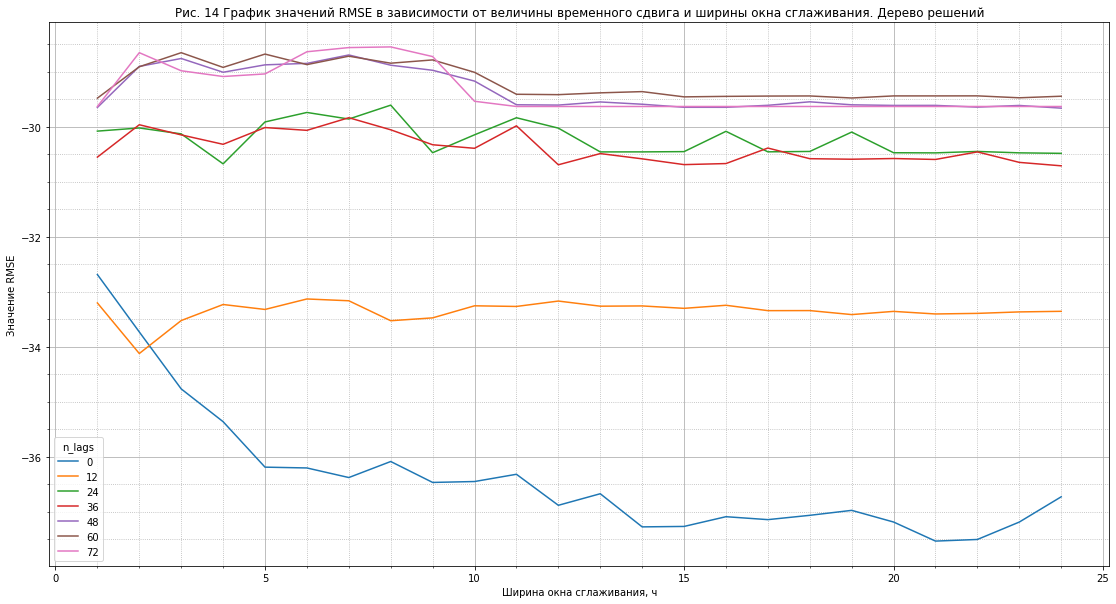

In [77]:
#построим график значений RMSE в зависимости от сочетания "количество лагов - ширина окна"
pd.DataFrame(dt_result).pivot_table(index='roll_size', columns='n_lags', values='score', aggfunc='min').plot(figsize=(19, 10))

#добавим оформление
plt.xlabel('Ширина окна сглаживания, ч')
plt.ylabel('Значение RMSE')
plt.title('Рис. 14 График значений RMSE в зависимости от величины временного сдвига и ширины окна сглаживания. Дерево решений')
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')

Наилучшая модель на основе дерева решений (**RMSE=28.6**) достигается при:
- количестве лагов 72;
- ширине скользящего окна 8;
- гиперпараметрах: {'max_depth': 5, 'min_samples_split': 9}.

## 3.5 Сравнение моделей

На текущем этапе сравним качество построенных моделей, полученное на кроссвалидации, и выберем лучшую.

In [78]:
#укажем в графе best_params для модели линейной регрессии дефолтные параметры
lr_result['best_params'] = 'default'
lr_result.head()

,n_lags,roll_size,score,best_params
0,0,1,-31.537845,default
1,0,2,-32.413946,default
2,0,3,-33.601983,default
3,0,4,-34.364820,default
4,0,5,-34.742873,default


In [79]:
#создадим сводные таблицы
pivot = pd.concat([lr_result.sort_values(by='score', ascending=False).head(1), 
                   lgbm_result.sort_values(by='score', ascending=False).head(1), 
                   dt_result.sort_values(by='score', ascending=False).head(1)])
pivot.index = ['ЛинРегр', 'ГрБуст', 'ДерРеш']
pivot

,n_lags,roll_size,score,best_params
ЛинРегр,36,21,-26.587318,default
ГрБуст,72,7,-23.715861,"{'max_depth': 6, 'n_estimators': 50, 'reg_lamb..."
ДерРеш,72,8,-28.551870,"{'max_depth': 5, 'min_samples_split': 9}"


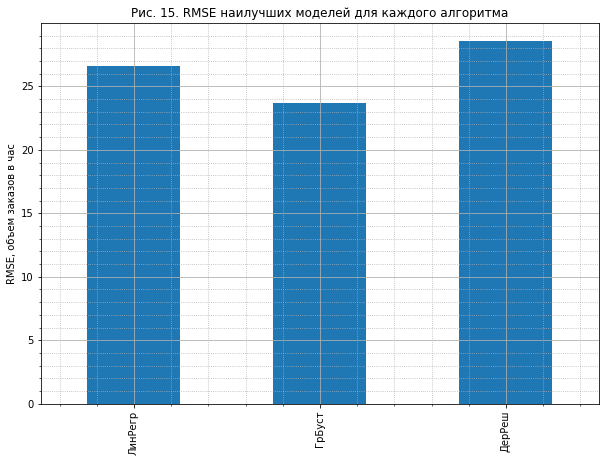

In [92]:
#построим слолбчатую диаграмму качества наилучших для каждого алгоритма моделей
abs(pivot['score']).plot(kind='bar', figsize = (10, 7))
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.ylabel('RMSE, объем заказов в час')
plt.title('Рис. 15. RMSE наилучших моделей для каждого алгоритма');

Анализируя полученные результаты, можно сделать следующие выводы:
- наихудшее качество (RMSE = 28.6) наблодается для модели на основе алгоритма дерева решений;
- промежуточное качество (RMSE = 26.6) наблюдается на модели линейной регрессии;
- наилучшее качество показала модель, обученная градиентным бустингом со значением RMSE=23.7. Примем ее в качестве итоговой и обучим ее заново на всей тренировочной выборке.

In [81]:
%%time

features_train, target_train, features_test, target_test = make_samples(df, 0.1, 72, 3)

best_model = LGBMRegressor(**pivot.loc['ГрБуст', 'best_params'])
best_model.fit(features_train, target_train)

CPU times: total: 766 ms
Wall time: 162 ms


LGBMRegressor(max_depth=6, n_estimators=50, reg_lambda=0)

# 4. Проверка модели на тестовой выборке

Оценим качество выбранной модели на тестовой выборке.

In [82]:
#выполним предсказание
predict = best_model.predict(features_test)

In [83]:
#оценим качество предсказзания
best_score = (mean_squared_error(predict, target_test))**0.5
best_score

39.87714499200712

Построим график временного ряда для тестовой выборки и предсказания.

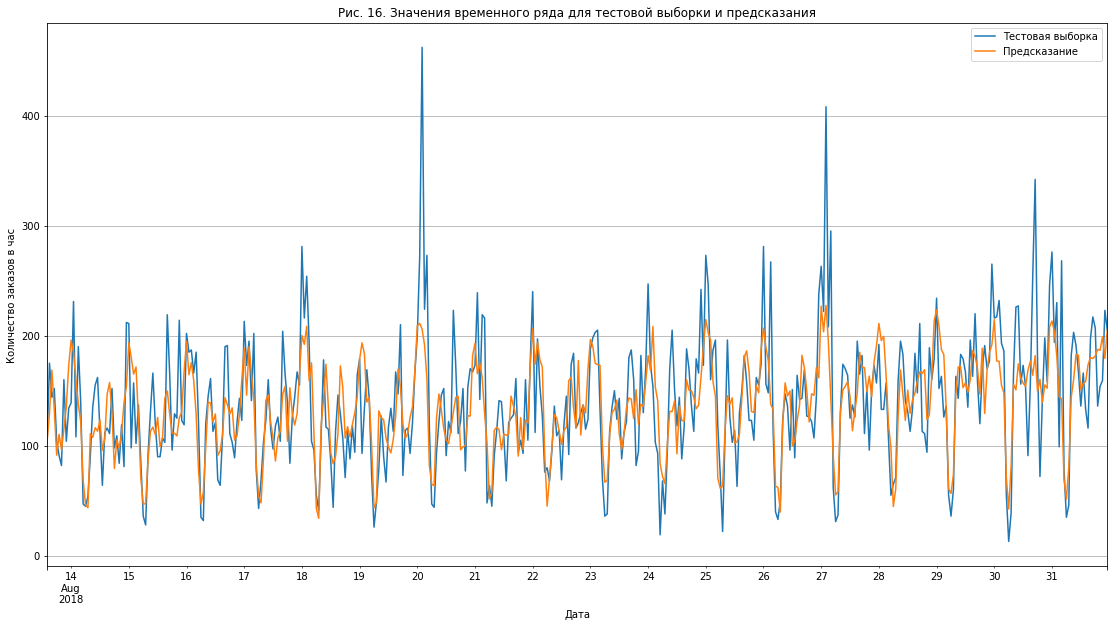

In [84]:
#построим график
plt.figure(figsize=(19,10))
target_test.plot(ax=plt.gca())
pd.DataFrame(predict, index=target_test.index, columns=['predict']).plot(ax=plt.gca(), grid=True)

#настроим оформление
plt.legend(['Тестовая выборка','Предсказание'], loc=1)
plt.title('Рис. 16. Значения временного ряда для тестовой выборки и предсказания')
plt.xlabel('Дата')
plt.ylabel('Количество заказов в час');

Выполним совместную декомпозицию временного ряда тестовой выборки и предсказания.

 

In [85]:
decomposed_test = seasonal_decompose(target_test)
decomposed_pred = seasonal_decompose(pd.DataFrame(predict, index=target_test.index, columns=['predict']))

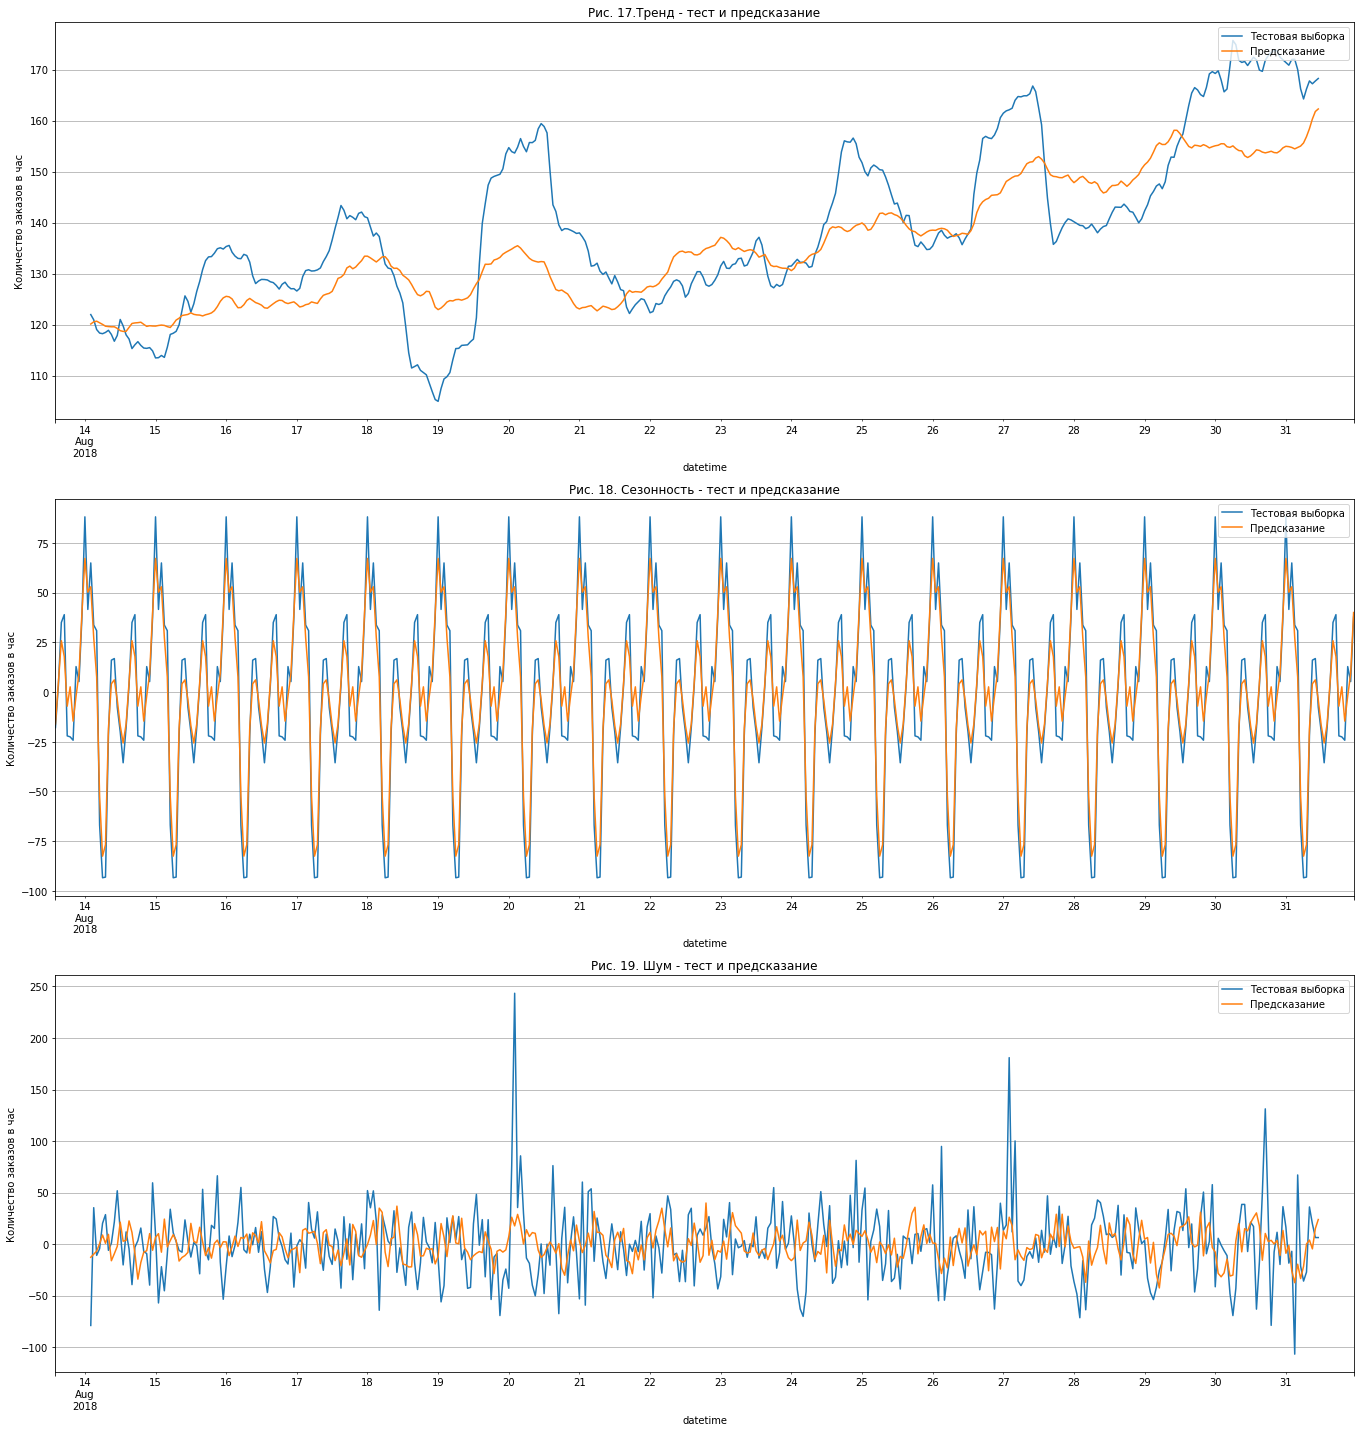

In [86]:
#построим графики

#график тренда
plt.figure(figsize=(19,20))
plt.subplot(311)
decomposed_test.trend.plot(ax=plt.gca(), grid=True)
decomposed_pred.trend.plot(ax=plt.gca(), grid=True)
plt.legend(['Тестовая выборка','Предсказание'], loc=1)
plt.ylabel('Количество заказов в час')
plt.title('Рис. 17.Тренд - тест и предсказание')

#график сезонности
plt.subplot(312)
decomposed_test.seasonal.plot(ax=plt.gca(), grid=True)
decomposed_pred.seasonal.plot(ax=plt.gca(), grid=True)
plt.legend(['Тестовая выборка','Предсказание'], loc=1)
plt.ylabel('Количество заказов в час')
plt.title('Рис. 18. Сезонность - тест и предсказание')

#график шума
plt.subplot(313)
decomposed_test.resid.plot(ax=plt.gca(), grid=True)
decomposed_pred.resid.plot(ax=plt.gca(), grid=True)
plt.legend(['Тестовая выборка','Предсказание'], loc=1)
plt.ylabel('Количество заказов в час')
plt.title('Рис. 19. Шум - тест и предсказание')

plt.tight_layout()

RMSE выбранной модели на тестовой выборке составляет 39.9, что не превышает максимально допустимого значения метрики $RMSE_{max}=48$. Модель неплохо уловила сезонную составляющую и тренд. Максимальная ошибка в оценке сезонной составляющей и тренда для модели составляет ~25 заказов в час, что не превышает допустимой RMSE. Модель плохо улавливает экстремальные значения, но это и не требуется. Ошибка предскзания локальных пиков, вероятно, вызвана качеством улавливания моделью сезонной составляющей исходного временного ряда. Дополнительно посмотрим, какие признаки имеют наибольший вес:

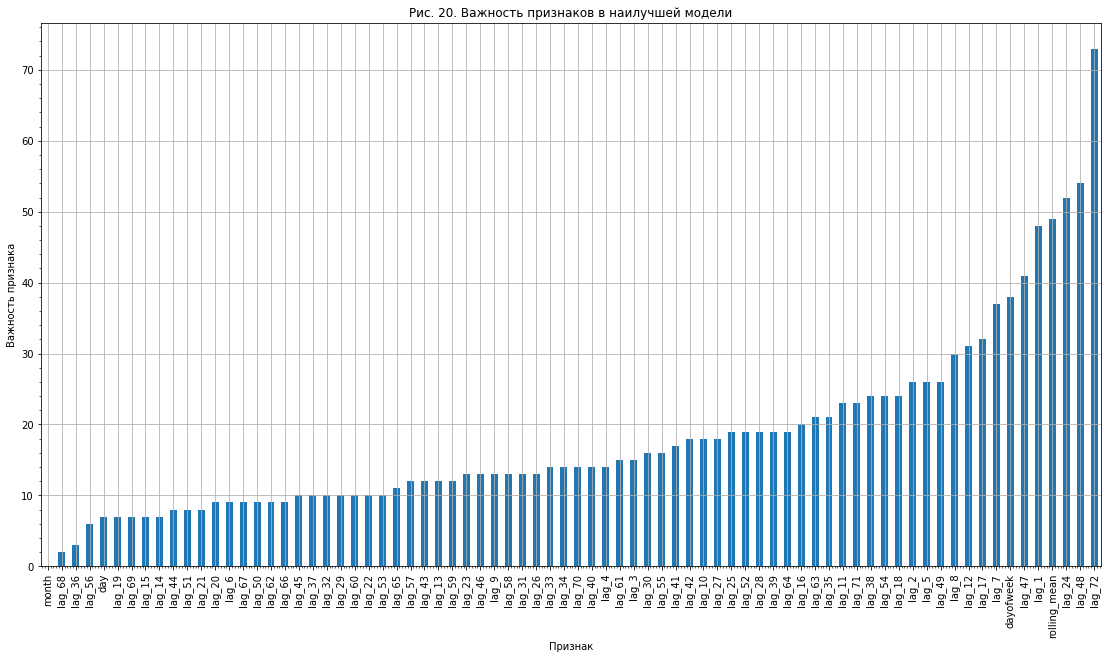

In [87]:
pd.Series(best_model.feature_importances_, index=features_train.columns).sort_values().plot(kind='bar', ylabel = 'Важность признака', xlabel='Признак', title='Важность признаков для модели LightGBM', figsize=(19, 10));
plt.minorticks_on()
plt.grid(which='major')
plt.title('Рис. 20. Важность признаков в наилучшей модели');

Наиболее важными признаками в наилучшей модели являются лаги по времени, кратные 24 ч: 24 ч, 48 ч, 72 ч - вес этих факторов более 50, для лага 72 ч - вес более 70. Следующие по важности факторы имеют одинаковые веса (~48) и представлены следующими признаками: скользящее среднее и 1-й лаг.

# 5. Проверка вменяемости модели

Для оценки вменяемости модели сравним ее с наилучшей из следующих моделей:
- константная модель (медиана);
- константная модель (среднее);
- модель прогнозирования предыдущим значением ряда.

In [88]:
#оценим точность прогноза медианным значеним
pred_median = np.ones(target_test.shape) * target_train.median()
print('RMSE константной модели с медианной стратегией', (mean_squared_error(pred_median, target_test))**0.5)

RMSE константной модели с медианной стратегией 87.15277582981295


In [89]:
#оценим точность прогноза средним значением
pred_mean = np.ones(target_test.shape) * target_train.mean()
print('RMSE константной модели со стратегией среднего', (mean_squared_error(pred_mean, target_test))**0.5)

RMSE константной модели со стратегией среднего 84.4709080778736


In [90]:
#оценим точность прогноза предыдущим значением
pred_prev = target_test.shift(fill_value=target_train.iloc[-1])
print('RMSE прогнозирования предыдущим значением', (mean_squared_error(pred_prev, target_test))**0.5)

RMSE прогнозирования предыдущим значением 58.856486242815066


Наилучший способ прогноза без обучения - прогноз предыдущим значением. RMSE такого предсказания составляет 58.86, что больше требуемого значения метрики (RMSE=48) и больше качества наилучшей построенной модели (градиентный бустинг, LightGBM) на тестовой выборке (RMSE=39.9). Обученная модель прогноза объема заказов такси вменяема.

# 6. Общий вывод

В рамках создания модели прогнозирования количества заказов такси в час было выполнено следующее:
- поготовка данных. Данные ресемплированы с шагом 1 час;
- выполнена декомпозиция временного ряда. Выявлена устойчивая суточная сезонная составляющая. Максимальное значение сезонности призодится на полночь, минимальное - на 6 часов утра. Временной ряд имеет восходящий тренд;
- обучены модели на основе следующих алгоритмов:
    - линейная регрессия;
    - случайный лес (обучение градиентным бустингом);
    - дерево решений;
- качество моделей оценивалось кроссвалидацией с помощью метрики RMSE. Совместно с оценкой качества моделей происходил подбор параметров создания признаков (количества лагов и ширины скользящего окна) и наилучших гиперпараметров (кроме линейной регрессии). Параметры, соответствующие наилучшим моделям для каждого алгоритма, а также точность на кроссвалидации приведены в таблице далее.

In [91]:
pivot

,n_lags,roll_size,score,best_params
ЛинРегр,36,21,-26.587318,default
ГрБуст,72,7,-23.715861,"{'max_depth': 6, 'n_estimators': 50, 'reg_lamb..."
ДерРеш,72,8,-28.551870,"{'max_depth': 5, 'min_samples_split': 9}"


- в качестве наилучшей модели c RMSE=26.6 принята **модель градиентного бустинга** с гиперпараметрами {max_depth=5, n_estimators=50, reg_lambda=0}. Для достижения указанной RMSE количество лагов в признаках обучающей выборки: 72, размер скользящего окна: 21.
- качество выбранной модели на тестовой выборке составило **RMSE=39.9** заказов в час;
- модель успешно прошла проверку на вменяемость.
- наиболее важные признаки 
    - с весом более 50 - кратные 24 ч. временные лаги: 24, 48, 72 ч.
    - с весом ~48: скользящее среднее и 1-й лаг.